In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [4]:
X_train = pd.read_csv('data/X_train.csv')
y_train = pd.read_csv('data/Y_train.csv').astype('category')
numeric_predictors = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
df = pd.concat([X_train, y_train], axis=1)
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Target
0,LP001032,Male,No,0,Graduate,No,4950,0.0,125,360,1,Urban,Y
1,LP001824,Male,Yes,1,Graduate,No,2882,1843.0,123,480,1,Semiurban,Y
2,LP002928,Male,Yes,0,Graduate,No,3000,3416.0,56,180,1,Semiurban,Y
3,LP001814,Male,Yes,2,Graduate,No,9703,0.0,112,360,1,Urban,Y
4,LP002244,Male,Yes,0,Graduate,No,2333,2417.0,136,360,1,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,LP002585,Male,Yes,0,Graduate,No,3597,2157.0,119,360,0,Rural,N
380,LP001841,Male,No,0,Not Graduate,Yes,2583,2167.0,104,360,1,Rural,Y
381,LP002820,Male,Yes,0,Graduate,No,5923,2054.0,211,360,1,Rural,Y
382,LP001744,Male,No,0,Graduate,No,2971,2791.0,144,360,1,Semiurban,Y


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Loan_ID            384 non-null    object  
 1   Gender             384 non-null    object  
 2   Married            384 non-null    object  
 3   Dependents         384 non-null    object  
 4   Education          384 non-null    object  
 5   Self_Employed      384 non-null    object  
 6   ApplicantIncome    384 non-null    int64   
 7   CoapplicantIncome  384 non-null    float64 
 8   LoanAmount         384 non-null    int64   
 9   Loan_Amount_Term   384 non-null    int64   
 10  Credit_History     384 non-null    int64   
 11  Property_Area      384 non-null    object  
 12  Target             384 non-null    category
dtypes: category(1), float64(1), int64(4), object(7)
memory usage: 36.6+ KB


<Figure size 864x864 with 0 Axes>

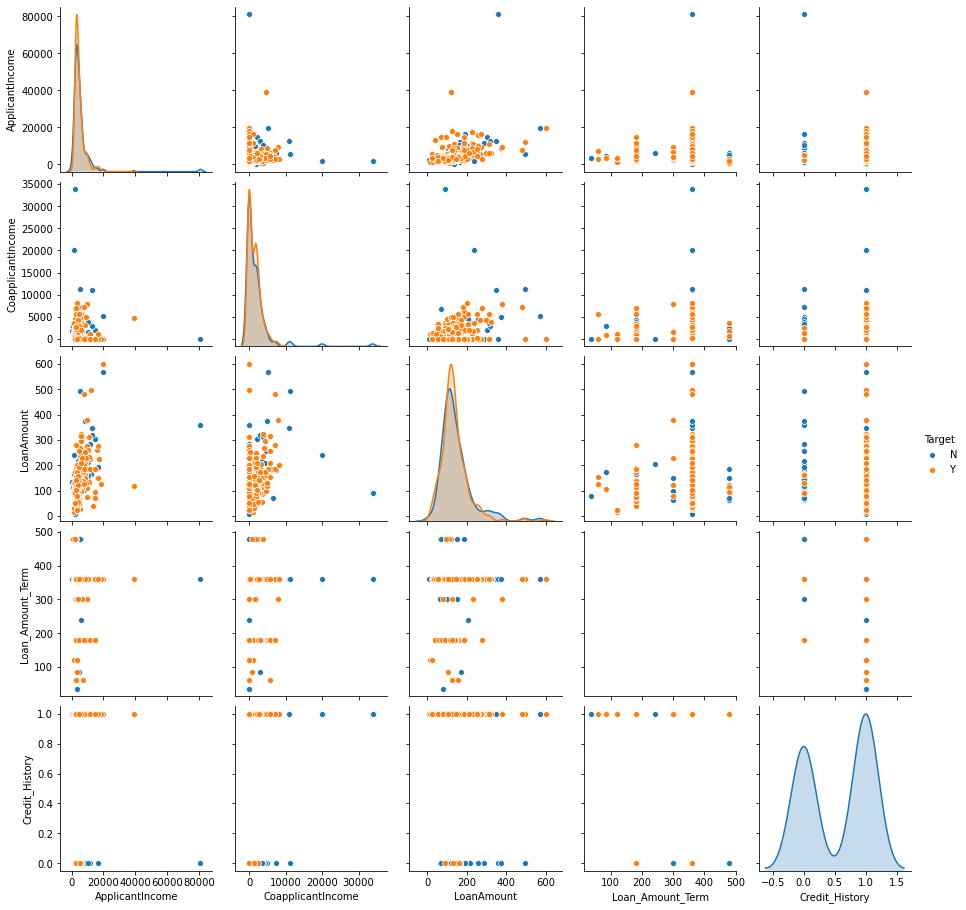

In [4]:
numeric_predictors = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
plt.figure(figsize=(12,12))
sb.pairplot(data=df, hue='Target')
plt.show()

In [15]:
# Write function to plot multiple variable to see distribution, outlier
def plot_dist_box(df, numeric_predictors=df.columns):
    n = len(numeric_predictors)
    plt.figure(figsize=(n*8, 2*6))
    k = 1
    for i in range(n):
        plt.subplot(2,n,k)
        sb.distplot(df[numeric_predictors[i]])
        plt.title('skew ratio: {:.2f}'.format(df[numeric_predictors[i]].skew()))
        k += 1
    
    for j in range(n):
        plt.subplot(2,n,k)
        sb.boxplot(y=df[numeric_predictors[j]])
        k += 1

    plt.show()

In [6]:
df[numeric_predictors].describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount
count,384.000000,384.000000,384.000000
mean,5149.718750,1572.077917,141.471354
std,5304.921764,2624.223119,75.176271
min,150.000000,0.000000,9.000000
25%,2898.750000,0.000000,100.000000
50%,3893.500000,1188.500000,128.000000
75%,5819.500000,2259.250000,164.250000
max,81000.000000,33837.000000,600.000000


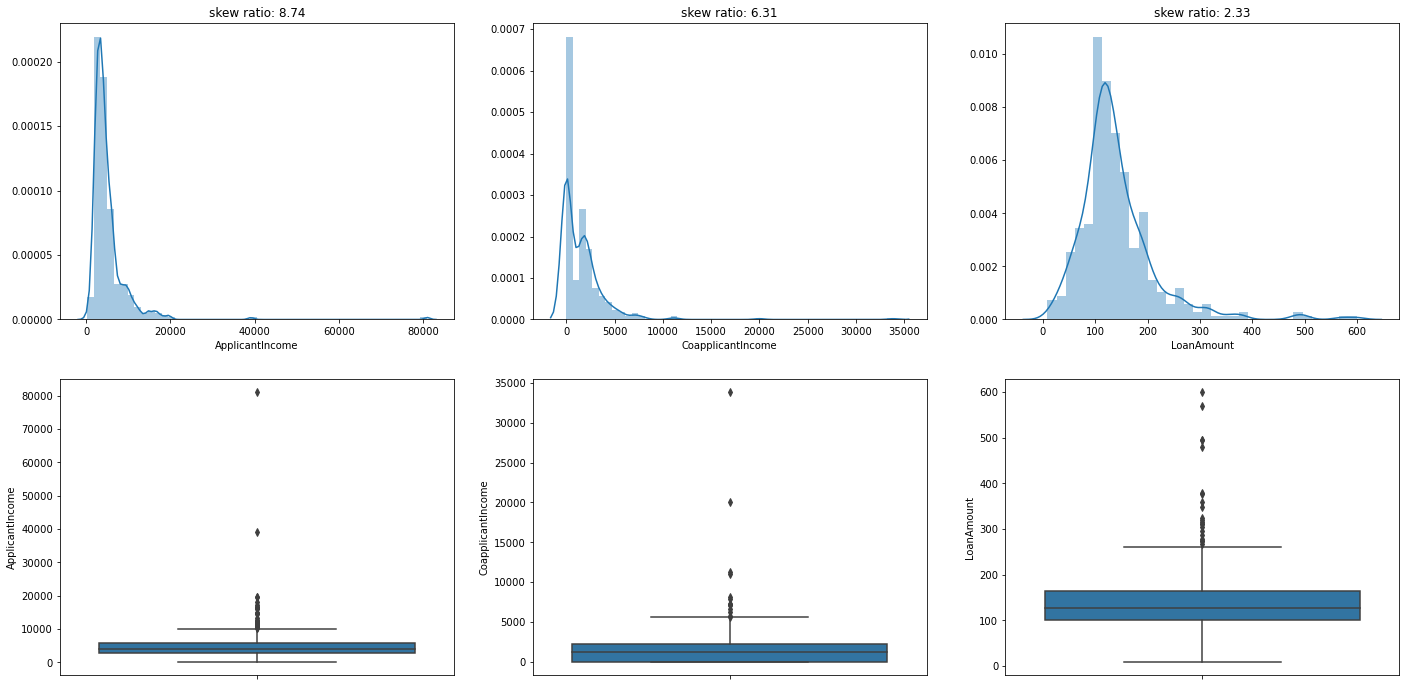

In [7]:
plot_dist_box(df, numeric_predictors)
# ApplicantIncome, CoapplicantIncome, LoanAmount have right skew and seem have upbound outlier.
# Because CoapplicantIncome have zero value, can not use log, so try sqrt.
# Try Log for ApplicantIncome, LoanAmount

In [8]:
def rm_outlier_by_z(df, predictors, threshold=3):
    #find absolute value of z-score for each observation
    z = np.abs(stats.zscore(df[predictors]))

    #only keep rows in dataframe with all z-scores less than absolute value of 3 
    df_clean = df[(z<threshold).all(axis=1)]
    return df_clean

def rm_outlier_by_iqr(df, predictors, threshold=1.5):
    #find Q1, Q3, and interquartile range for each column
    Q1 = df[predictors].quantile(q=.25)
    Q3 = df[predictors].quantile(q=.75)
    IQR = df[predictors].apply(stats.stats.iqr)

    #only keep rows in dataframe that have values within 1.5*IQR of Q1 and Q3
    df_clean = df[~((df[predictors] < (Q1 - threshold * IQR)) | (df[predictors] > (Q3 + threshold * IQR))).any(axis=1)]
    return df_clean

In [16]:
def sqrt_predictors(df, predictors=df.columns):
    for i in predictors:
        new_col = '{}_sqrt'.format(i)
        df[new_col] = np.sqrt(df[i])

def log_predictors(df, predictors):
    for i in predictors:
        new_col = '{}_log'.format(i)
        df[new_col] = np.log(df[i])

In [17]:
def scaler_data(df, predictors=df.columns, method='StandardScaler'):
    
    if method == 'MinMaxScaler':
        scaler = MinMaxScaler()
    elif method == 'RobustScaler':
        scaler = RobustScaler()
    else:
        scaler = StandardScaler()
    
    df[predictors] = scaler.fit_transform(df[predictors])

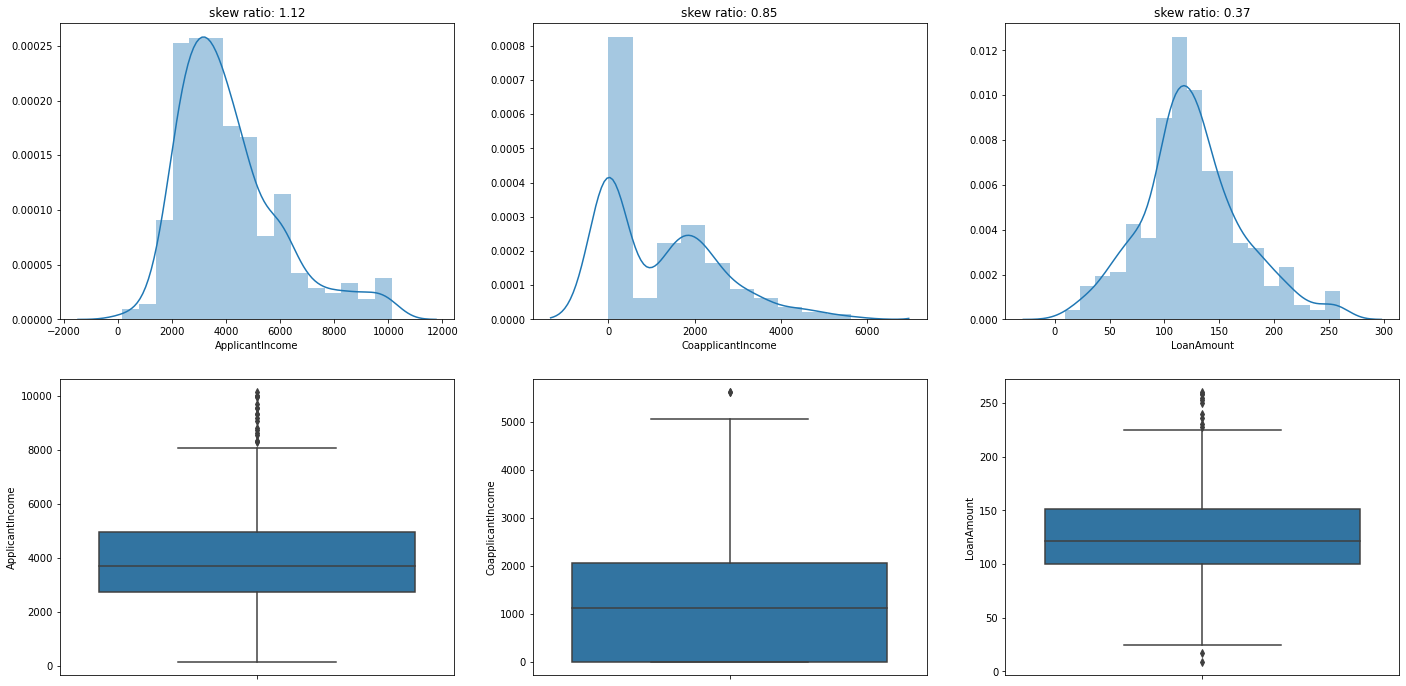

In [11]:
df_new = pd.DataFrame()
df_new = rm_outlier_by_iqr(df, numeric_predictors, threshold=1.5)
plot_dist_box(df_new, numeric_predictors)

In [12]:
print(df.shape)
print(df_new.shape)

(384, 13)
(336, 13)


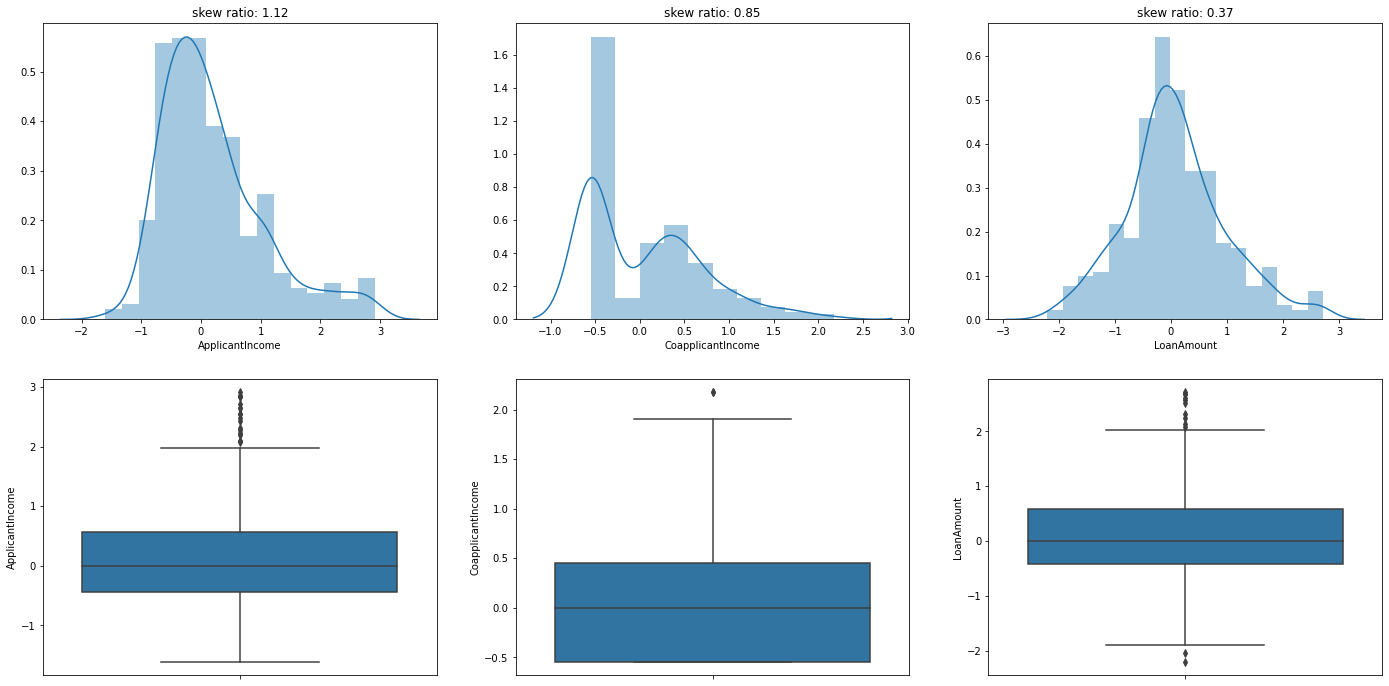

In [13]:
# df_new = df.copy()
scaler_data(df_new, numeric_predictors, method='RobustScaler')
plot_dist_box(df_new, numeric_predictors)

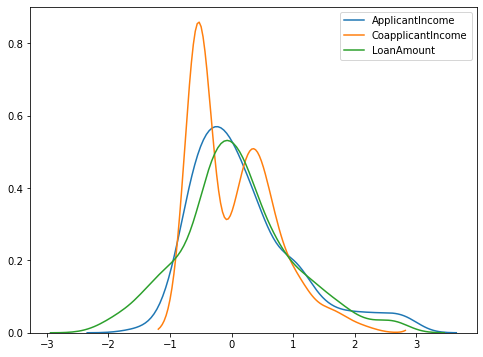

In [14]:
plt.figure(figsize=(8,6))
for i in numeric_predictors:
    sb.kdeplot(df_new[i])
plt.show()

In [60]:
# df_new = df.copy()
# sqrt_predictors(df_new, ['CoapplicantIncome'])
# log_predictors(df_new, ['ApplicantIncome', 'LoanAmount'])

# normalized_predictors = ['CoapplicantIncome_sqrt', 'ApplicantIncome_log', 'LoanAmount_log']
# plot_dist_box(df_new, normalized_predictors)